In [1]:
#set random seeds
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(1)

import pandas as pd
import numpy as np

#machine learning
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers 
from tensorflow import keras
from sklearn.model_selection import train_test_split

#accessing files
from google.cloud import storage
import os

#display charts/images
import matplotlib.pyplot as plt

#don't need
from tensorflow.python.keras.preprocessing import sequence
# from tensorflow.python.keras.preprocessing import text
import tensorflow_hub as hub

import json




2.3.0


In [2]:
params = {
    'image_size': [299, 299],
    'text_input': (58,),
    'batch_size': 512,
    'vocab_size': 30000,
    'examples_per_file': 850, #will not change
    'train_size':8500,
    'test_examples_per_file': 500,
    'test_size': 1000,
    'version': 16, #model version number
    'caption_text_input_length': 49,
    'caption_model_version': 5,
    'meme_text_length': 58,
    'caption_embedding_dim': 300,
    'caption_vocab_size' : 10000,
    'tokenizer_start_index': 58, #index of tokenizer to signal sequence start
    'tokenizer_end_index': 57,

}




In [3]:
try:
    from google.colab import auth
    auth.authenticate_user()
    credentials=None

except ModuleNotFoundError:


    from google.oauth2 import service_account

    credentials = service_account.Credentials.from_service_account_file( #file location of GCS private key
        '/Users/jeremiahherberg/Downloads/hateful-memes-af65c70c1b79.json')

client = storage.Client(project='hateful-memes', credentials=credentials)

In [4]:
bucket = 'jh_hateful_memes'
glove_bucket = 'kds-5123f8991f380aa8ec3a0dfae64a3732b529d4e504450dd8f9e55fb1'
caption_token_bucket = 'kds-e7996502fe373b391a0a14641ad5f932ee7d607744dbe970cc8ffe08'
client = storage.Client(project='hateful-memes', credentials=credentials)


In [5]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.27.233.242:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.27.233.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.27.233.242:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [6]:
def decode_example_train(example):
    '''
    decodes single tfexample from TFrecord file
    '''
    features = {'label': tf.io.FixedLenFeature([], tf.int64),
                'text': tf.io.FixedLenFeature([], tf.string),
                'text_lemma': tf.io.FixedLenFeature([], tf.string),
                'text_lemma_no_stopwords': tf.io.FixedLenFeature([], tf.string),
                'text_no_stopwords':tf.io.FixedLenFeature([], tf.string),
                'image': tf.io.FixedLenFeature([], tf.string)}
    single_example = tf.io.parse_single_example(example, features)
    
    text = tf.io.parse_tensor(single_example['text'], out_type=tf.int32)
    textL = tf.io.parse_tensor(single_example['text_lemma'], out_type=tf.int32)
    # text = tf.cast(text, tf.float32) 
    image = tf.io.decode_jpeg(single_example['image'], 3)
    image = tf.image.resize_with_pad(image, *params['image_size'])
    image = image / 127.5
    image = image -1
    label = single_example['label']
    # label = tf.cast(label, tf.float32)
    return text, image, label

def decode_example_test(example):
    '''
    decodes single tfexample from TFrecord file
    '''
    features = {'id': tf.io.FixedLenFeature([], tf.int64),
                'text': tf.io.FixedLenFeature([], tf.string),
                'text_lemma': tf.io.FixedLenFeature([], tf.string),
                'text_lemma_no_stopwords': tf.io.FixedLenFeature([], tf.string),
                'text_no_stopwords':tf.io.FixedLenFeature([], tf.string),
                'image': tf.io.FixedLenFeature([], tf.string)}
    single_example = tf.io.parse_single_example(example, features)
    
    text = tf.io.parse_tensor(single_example['text'], out_type=tf.int32)
    textL = tf.io.parse_tensor(single_example['text_lemma'], out_type=tf.int32)
    # text = tf.cast(text, tf.float32) 
    image = tf.io.decode_jpeg(single_example['image'], 3)
    image = tf.image.resize_with_pad(image, *params['image_size'])
    image = image / 127.5
    image = image -1
    label = single_example['id']
    # label = tf.cast(label, tf.float32)
    return text, image, label

def flip_image(text, image, label): 
    '''
    randombly flips image input
    
    args:
        text: text output in ds
        image: image output in ds
        label: label output in ds (can also be id)
    returns:
        text, image, label
        args will be otherwise unchanged
    '''
    
    image = tf.image.random_flip_left_right(image)

    return text, image, label


def convert_xy(text, image, label): #needs to be called last
    '''
    transforms ds output from text, image, label -> (text, image), label
    
    args:
        text: text output in ds
        image: image output in ds
        label: label output in ds (can also be id)
    returns:
        (text, image), label
        args will be otherwise unchanged
    '''
    return (text, image), label
    
    

In [7]:
def create_ds(params, client, bucket, prefix, is_training):
    '''
    creates dataset from CSV file 
    args:
        params, dictionary with the following key:
            caption_model_version: int, image caption version number
            train_size: int, dataset size of training data
            test_size: int, dataset size of test data
        client: google.cloud.storage.Client object,
        bucket: bucket CSV files are located in
        prefix: str, prefix to append to the beginng of each file name
        is_training: Bool, indicator if the DS is for training/validation or testing
    '''
    caption_version = params['caption_model_version']
    text_file = '{}_caption_model_text_v{}.csv'.format(prefix, caption_version)
    caption_file = '{}_caption_model_captions_v{}.csv'.format(prefix, caption_version)
    label_file = '{}_caption_model_label_v{}.csv'.format(prefix, caption_version)
    for file in [text_file, caption_file, label_file]:
        if not os.path.isfile(file):
            download_file(client, bucket, file)
    text = pd.read_csv(text_file)
    caption = pd.read_csv(caption_file)
    labels = pd.read_csv(label_file)
    ds = tf.data.Dataset.from_tensor_slices(((caption.values, text.values), labels.values))
    if is_training:
        batch_size = params['train_size']
    else:
        batch_size = params['test_size']
    ds = ds.batch(batch_size)
    return ds

    

In [8]:
def download_file(client, bucket, file_name):
    '''
    downloads a file from a GCS bucket into working directory

    args:
        client: google.cloud.storage.Client object
        bucket: str, name of bucket to download file from
        file_name: str, file name to download
    returns: None
    
    '''
    _bucket = client.bucket(bucket)
    blob = _bucket.blob(file_name)
    blob.download_to_filename(file_name)
    

def create_tokenizer_from_filename(file_name,
                                  bucket_=None,
                                  client_=None):
    '''
    creates tf.keras.preprocessing.text.tokenizer from a 
    json config file in current working directory
    args:
        client_: google.cloud.storage.Client object
        file_name: str, filename where config json file is located
        bucket_, str, default None, name of GCS bucket with an object with the
            same file name as glove_file, if an arg
            is passed, function will first check if file_name exists in current
            directory, and if not, will download an object located at file_name
            in the bucket passed into bucket arg
    returns:
        tokenizer object
    '''
    if bucket:
        if not os.path.isfile(file_name):
            download_file(client_, bucket_,file_name)
    with open(file_name) as file:
        open_file = json.load(file)
        tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(open_file)
    return tokenizer

def get_embedding_weights_from_tokenizer_glove(glove_file,
                                              tokenizer,
                                              embedding_dim,
                                              bucket=None,
                                               client=None
                                              ):
    '''
    gets the weights to use in an embedding layer from a pretained
    model based on the tokenizer used to create sequences that will
    be passed into embedding layer
    
    args:
        glove_file: str, path of pretrained model from current directory
        tokenizer: tf.keras.preprocessing.text.tokenizer object, tokenizer
            that was used to create sequences
        embedding_dim: int, output_dim of embedding layer of pre-trained model
        bucket, str, default None, name of GCS bucket with an object with the
            same file name as glove_file, if an arg
            is passed, function will first check if glove_file exists in current
            directory, and if not, will download an object located at glove_file
            in the bucket passed into bucket arg
    returns: 
        embedding_weights: numpy array, shaped* (vocab_size, embedding_dim)
            weights that can be used for embedding layer
            *vocab_size = tokenizer.num_words which is the number of words in
            the tokenizer vocabulary
        
    '''
    if bucket:
        if not os.path.isfile(glove_file):
            download_file(client, bucket, glove_file)
    word_values = dict()
    file = open(glove_file, encoding='utf-8')
    
    for line in file:
        coeff = line.split()
        word = coeff[0]
        coefficients = np.asarray(coeff[-embedding_dim:], dtype='float32')
        word_values[word] = coefficients

            
    file.close()
    vocab_size = tokenizer.num_words
    embedding_weights = np.zeros((vocab_size, embedding_dim))
    for word, idx in tokenizer.word_index.items():
        if idx < vocab_size:
            word_embedding_values = word_values.get(word)
            if word_embedding_values is not None:
                embedding_weights[idx] = word_embedding_values
    
    return embedding_weights

In [9]:
def pair_separableConv1D(x, 
                         filters, kernal_size, act, first_reg, sec_reg,
                        maxpooling_poolsize):
    '''
    function to add the following layers to a Keras Functional model:
        layers.SeparableConv1D
        layers.SeparableConv1D
        layers.MaxPooling1D
    
    args:
        x: keras input layer, or series of layers that can be traced to input layer
        kernal_size: int, kernal size for SeparableConv1D layers
        act: str, activation for SeparableConv1D layers
        first_reg, keras regularizer to pass into 1st conv layer
        sec_reg, keras regularizer to pass into 2nd conv layer
        maxpooling_poolsize: int, poolsize for maxpooling layer
    
    returns:
        x: x that was input into fn with above layers added
    '''
    x = layers.SeparableConv1D(filters=filters, kernel_size=kernal_size, 
                              activation=act, padding='same',
                              kernel_regularizer=first_reg)(x)
    x = layers.SeparableConv1D(filters=filters, kernel_size=kernal_size, 
                              activation=act, padding='same',
                              kernel_regularizer=sec_reg)(x)
    x = layers.MaxPooling1D(pool_size=maxpooling_poolsize, padding='same')(x)
    x = layers.BatchNormalization()(x)
    return x

In [10]:
def conv2dset(x, 
              conv_filter, kernel, regularizer=None, 
              maxpooling_poolsize=2, 
              conv_act=None, 
              dense_units=None, dense_act=None):
    '''
    function to add the following layers to a Keras Functional model:
        layers.Conv2D
        MaxPooling2D
        Batchnormalization
        (activation layer)
        layers.Dense (if applicable)
    
    args:
        x: keras input layer, or series of layers that can be traced to input layer
        conv_filter: int, number of filters in Conv2D layer
        kernel: int, kernel size in Conv2D layer
        regularizer: keras.regularizers object, default: None, regularizer in 
            Conv2D layer
        maxpooling_poolsize: int, default 2, poolsize for maxpooling layer
        conv_act: keras layer (without the "()"), default None, activation
            layer that will go after the batchnormalization layer
        dense_units: int, default None, number of units in dense layer
            if None, there will be no dense layer
        dense_act: str, default None, activation in dense layer
    
    returns:
        x: x that was input into fn with above layers added
        
    '''
    x = layers.Conv2D(filters=conv_filter, kernel_size=kernel, padding='same', 
                      kernel_regularizer=regularizer)(x)
    if maxpooling_poolsize:
        x = layers.MaxPooling2D(maxpooling_poolsize)(x)
    # x = layers.BatchNormalization()(x)
    if conv_act:
        x = conv_act()(x)
    if dense_units:
        x = layers.Dense(dense_units, activation=dense_act)(x)
    
    return x

def convblock(x, conv_fn, filters, regularizer, conv_act, kernal=5):
    '''
    makes a block of convolution layers
    
    todo -- work on documentation 
    '''
    count = 0
    for _ in range(2):
        for filter_ in filters:
            count +=1
            if count == 2:
                x1 = conv_fn(x, filter_, kernal, regularizer, 2, conv_act,)
                x = x1
            else:
                x = conv_fn(x, filter_, kernal, regularizer, None, conv_act)
    x = layers.Add()([x, x1])
    return x



In [11]:
def create_model(params=params,
                dense_nodes=128,
                ltsm_units=128,
                ltsm_dense_units=64,
                caption_embedding=None,
                text_embedding=None):
    '''
    creates model with two inputs and out output

        
    '''
    #set some fixed variables
    text_input_shape = params['text_input']
    vocab_size = params['vocab_size']
    image_size = params['image_size']
    caption_input_len = params['caption_text_input_length']
    meme_text_len = params['meme_text_length']
    caption_dim = params['caption_embedding_dim']
    caption_vocab_size = params['caption_vocab_size']
    

    relu = layers.ReLU
    leaky = layers.LeakyReLU
    reg = keras.regularizers.l2(0.001,)
    dense_act = None
    
    #model inputs
    input_text = layers.Input(text_input_shape, name='text_input')
    embedding = layers.Embedding(input_dim=vocab_size, output_dim=300,  #300
                                 input_length=meme_text_len, mask_zero=True)(input_text)
    embedding = layers.Dropout(0.5)(embedding)

    
    input_caption = layers.Input((caption_input_len,), name='caption_input')
    embedding_caption = layers.Embedding(input_dim=caption_vocab_size, output_dim=caption_dim, #caption_dim
                                         input_length=caption_input_len, mask_zero=True)(input_caption)
    embedding_caption = layers.Dropout(0.5)(embedding_caption)



    text = layers.Concatenate(axis=1)([embedding_caption, embedding])

    # # bidirectional
    text = layers.Bidirectional(layers.LSTM(ltsm_units, return_sequences=False))(text)
    text = layers.Dense(ltsm_dense_units, activation = 'relu')(text)
    text = layers.Dense(dense_nodes, activation=None)(text)
    # text = layers.LeakyReLU()(text)

        


    x = text
    

    final_output = layers.Dense(1, activation='sigmoid', name='final_out')(x)
    

    
    model = keras.Model([input_caption, input_text], final_output) #input_image
    model.layers[2].set_weights([caption_embedding])
    model.layers[2].trainable = False
    
    model.layers[3].set_weights([text_embedding])
    model.layers[3].trainable = False
    metrics = [
          keras.metrics.TruePositives(name='tp'),
    #           keras.metrics.FalsePositives(name='fp'),
    #           keras.metrics.TrueNegatives(name='tn'),
          keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.BinaryAccuracy(name='accuracy'),
    #           keras.metrics.Precision(name='precision'),
    #           keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc'),
    ]
    schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.0003, 27 *6, 0.65) #10 *3
    model.compile(
    optimizer=tf.keras.optimizers.Adam(schedule),
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.01),
    metrics=metrics)
    
    return model
    
    



In [12]:
data_set = create_ds(params, client, bucket,
                    'training', True)
for data in data_set:
    ds = data
    break
caption_tokenizer = create_tokenizer_from_filename('coco_tokenizer.json', 
                                           caption_token_bucket, client)
caption_embedding = get_embedding_weights_from_tokenizer_glove('glove.840B.300d.txt',
                                                               caption_tokenizer,
                                                               300,
                                                               glove_bucket, 
                                                               client)

text_tokenizer = create_tokenizer_from_filename('tokenizer.json', 
                                           bucket, client)
text_embedding = get_embedding_weights_from_tokenizer_glove('glove.840B.300d.txt',
                                                               text_tokenizer,
                                                               300,
                                                               glove_bucket, client)


In [13]:
tf.random.set_seed(1)
np.random.seed(1)
with strategy.scope():
    model = create_model(caption_embedding=caption_embedding,
                         text_embedding=text_embedding)
    model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
caption_input (InputLayer)      [(None, 49)]         0                                            
__________________________________________________________________________________________________
text_input (InputLayer)         [(None, 58)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 49, 300)      3000000     caption_input[0][0]              
__________________________________________________________________________________________________
embedding (Embedding)           (None, 58, 300)      9000000     text_input[0][0]                 
_______________________________________________________________________________________

In [14]:
#calculate class weights
target_0 = 5450 #these values will not change (are from review of test ds)
target_1 = 3050
total = target_0 + target_1

class_weight_0 = (1 / target_0) * (total) / 2.0
class_weight_1 = (1 / target_1) * (total) / 2.0

class_weights = {0: class_weight_0, 1: class_weight_1}

#early stopping if validation auc stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc',
                                patience=5,
                                mode='max',
                                restore_best_weights=True)

history = model.fit(x=(ds[0]), y=ds[1], 
                    validation_split=0.2, 
                    epochs=250, 
                    class_weight=class_weights, 
                    callbacks=[early_stopping],
                    steps_per_epoch=27)

Epoch 1/250
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


 1/27 [>.............................] - ETA: 0s - loss: 0.7184 - tp: 71.0000 - fn: 34.0000 - accuracy: 0.4802 - auc: 0.4812WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0045s vs `on_train_batch_end` time: 0.0360s). Check your callbacks.


27/27 [==============================] - ETA: 0s - loss: 0.6835 - tp: 1204.0000 - fn: 1211.0000 - accuracy: 0.5707 - auc: 0.5763WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0027s vs `on_test_batch_end` time: 0.0214s). Check your callbacks.


27/27 [==============================] - 9s 345ms/step - loss: 0.6835 - tp: 1204.0000 - fn: 1211.0000 - accuracy: 0.5707 - auc: 0.5763 - val_loss: 0.6661 - val_tp: 349.0000 - val_fn: 255.0000 - val_accuracy: 0.6418 - val_auc: 0.6685
Epoch 2/250
27/27 [==============================] - 3s 121ms/step - loss: 0.6551 - tp: 1452.0000 - fn: 963.0000 - accuracy: 0.6106 - auc: 0.6573 - val_loss: 0.6034 - val_tp: 246.0000 - val_fn: 358.0000 - val_accuracy: 0.6835 - val_auc: 0.6935
Epoch 3/250
27/27 [==============================] - 3s 128ms/step - loss: 0.6312 - tp: 1408.0000 - fn: 1007.0000 - accuracy: 0.6600 - auc: 0.6964 - val_loss: 0.6399 - val_tp: 403.0000 - val_fn: 201.0000 - val_accuracy: 0.6518 - val_auc: 0.7154
Epoch 4/250
27/27 [==============================] - 4s 132ms/step - loss: 0.6179 - tp: 1512.0000 - fn: 903.0000 - accuracy: 0.6600 - auc: 0.7160 - val_loss: 0.6083 - val_tp: 360.0000 - val_fn: 244.0000 - val_accuracy: 0.6912 - val_auc: 0.7248
Epoch 5/250
27/27 [===============

In [15]:
def plot_metric(metric1, metric2, ylabel):
    plt.plot(history.history[metric1], label=metric1)
    plt.plot(history.history[metric2], label=metric2)
    plt.ylabel(ylabel)
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

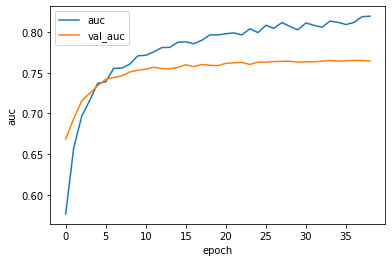

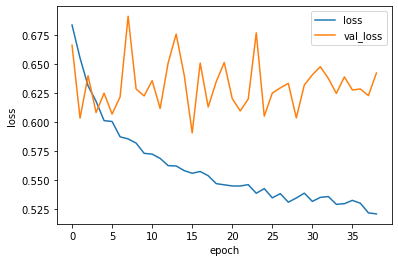

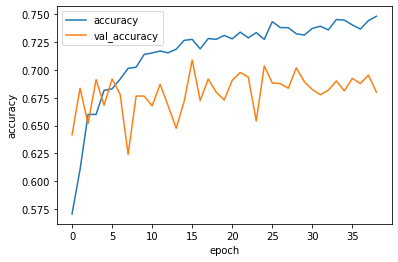

In [17]:
plot_metric('auc', 'val_auc', 'auc')
plot_metric('loss', 'val_loss', 'loss')
plot_metric('accuracy', 'val_accuracy', 'accuracy')

In [19]:
max(history.history['val_auc']) 

0.7652307748794556

In [20]:
model_name = 'model_hateful_memes_v{}.h5'.format(params['version'])
model.save(model_name)
bucket_ = client.bucket('jh_hateful_memes')
blob = bucket_.blob(model_name)
blob.upload_from_filename(model_name)#fix this

In [21]:
test_ds = create_ds(params, client, bucket, 'test_seen', False)

In [22]:
for x_test, ids in test_ds:

    test_text, test_images = x_test
    predictions = model.predict(x_test, steps=10)
    prediction_ids = ids



In [23]:
prediction_dict = {
    'id': np.concatenate(prediction_ids.numpy()),
    'proba': np.concatenate(predictions),
    'label': np.ones(1000, int)
}
submission_ds = pd.DataFrame(prediction_dict)



In [24]:
submission_ds.to_csv('submission.csv', index=False)

In [ ]:
import requests

In [ ]:
url = 'http://ipinfo.io/json'
response = requests.get(url)
response.text

'{\n  "ip": "35.192.85.19",\n  "hostname": "19.85.192.35.bc.googleusercontent.com",\n  "city": "Council Bluffs",\n  "region": "Iowa",\n  "country": "US",\n  "loc": "41.2619,-95.8608",\n  "org": "AS15169 Google LLC",\n  "postal": "51502",\n  "timezone": "America/Chicago",\n  "readme": "https://ipinfo.io/missingauth"\n}'